# CADD Score Optimization for ClinVar Variants

## Overview
This notebook implements a comprehensive analysis pipeline for optimizing CADD score thresholds across different genomic regions using ClinVar variant classifications. The analysis includes:

1. **Data preprocessing and standardization**
2. **Statistical analysis of CADD scores by genomic region**
3. **Threshold optimization using ROC and PR curves**
4. **Visualization and validation of results**

## Key Features
- ANNOVAR functional annotation standardization
- Enhanced Youden's J statistic normalization
- Category-specific threshold optimization
- Comprehensive statistical testing
- Production-ready filtering functions

---

# ClinVar Classification System Implementation Report

## Overview
This document details the implementation of ClinVar's variant classification system according to ACMG/AMP guidelines and ClinGen recommendations.

## Classification Categories

### Primary Classifications
```python
CLASSIFICATION_MAPS = {
    'pathogenic': {
        'pathogenic',
        'likely pathogenic',
        'pathogenic, low penetrance',
        'likely pathogenic, low penetrance',
        'established risk allele',
        'likely risk allele'
    },
    'benign': {
        'benign',
        'likely benign'
    },
    'uncertain': {
        'uncertain significance',
        'uncertain risk allele'
    }
}
```

### Special Classifications
```python
    'empty': {
        '',
        'not provided',
        'no classification for the single variant'
    },
    'conflict_terms': {
        'affects',
        'association',
        'protective',
        'risk factor',
        'drug response',
        'other',
        'confers sensitivity'
    }
```

## Implementation Details

### 1. Classification Hierarchy
- **Pathogenic variants**: Include standard pathogenic and low penetrance variants
- **Benign variants**: Include both benign and likely benign
- **Uncertain significance**: Includes VUS and uncertain risk alleles
- **Conflict handling**: Automatically detects mixed classifications

### 2. Key Rules Implemented


Classification rules:

1. Multiple primary classifications = Conflict
2. Any conflict term + primary classification = Conflict
3. Low penetrance must be paired with pathogenic/likely pathogenic
4. Empty/missing values = Empty



### 3. Conflict Detection Logic
- Mixed primary classifications (e.g., pathogenic + benign)
- Presence of conflict terms with primary classifications
- Invalid low penetrance combinations
- Unrecognized or novel terms

### Standardization of ANNOVAR Genomic Functional Annotations

In ANNOVAR outputs, genomic features occasionally receive compound labels when variants overlap multiple functional regions. These double-labeled variants create analytical challenges when optimizing thresholds by functional category.

We implemented a systematic annotation standardization approach with the following characteristics:

**Methodology:**
1. **Priority-based classification:** When resolving compound annotations, we prioritized the less common functional category. The specific handled cases were:
   - "exonic;splicing" → "Splicing" (prioritizing splice sites over general exonic regions)
   - "ncRNA_exonic;splicing" → "ncRNA Splicing" (prioritizing splice impact in non-coding RNAs)
   - "UTR5;ncRNA 5'UTR" → "ncRNA 5UTR" (preserving non-coding RNA context)
   - "downstream" combinations → "Downstream" (preserving downstream regulatory context)

**Impact:**
This standardization affected only a small fraction of variants but was essential for ensuring each variant had exactly one functional category assignment, enabling more reliable threshold optimization by genomic context. The approach preserves the biologically most relevant annotation when variants span multiple genomic features.

### Enhancement to Threshold Optimization: Normalized Youden's J Statistic

In the revised implementation, we normalized the traditional Youden's J statistic (TPR-FPR) using the formula:

J_normalized = (TPR-FPR+1)/2

**Rationale:**
1. **Range Standardization:** The original Youden's J metric ranges from -1 (worst) to +1 (best), while metrics like F1-score range from 0 to 1. This difference in scale creates an imbalance when combining metrics in the weighted approach.

2. **Improved Combinatorial Properties:** By transforming Youden's J to a 0-1 scale, we achieve more intuitive and mathematically sound weighting with the F1-score. When weight_roc=0.5, both metrics now contribute equally to the combined optimization score.

3. **Statistical Consistency:** The normalization preserves the ordinal properties of the original statistic while allowing for more direct interpretation relative to other classification performance metrics.

This change results in more balanced threshold selection, particularly in categories where ROC and PR curves have significantly different optimal operating points.

Traditional Youden's J statistic (TPR-FPR) gives us a value between -1 and +1, with:
- **+1** representing perfect classification
- **0** representing random chance
- **-1** representing inverse classification

By applying the transformation ((TPR-FPR+1)/2), we rescale this range to 0-1, where:
- **1** represents perfect classification
- **0.5** represents random chance
- **0** represents inverse classification

This rescaling makes Youden's J directly comparable to other metrics like F1-score, leading to more balanced threshold selection when we combine multiple optimization criteria.

# 1. Library Imports and Setup

This section imports all necessary libraries for data processing, statistical analysis, and visualization.

In [1]:
from IPython.display import display
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from collections import OrderedDict
import numpy as np
import seaborn as sns
from pathlib import Path
from typing import Dict, Optional
import logging
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as colors

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Function Definitions

This section contains all the custom functions used throughout the analysis pipeline.

In [2]:
# Functions

def load_data(
    file_path: Path | str,
    missing_values: Optional[list] = None,
    rename_cols: Optional[Dict[str, str]] = None
) -> pd.DataFrame:
    """
    Load and process ClinVar data with validation
    
    Args:
        file_path: Path to parquet file
        missing_values: List of values to treat as NA/NaN
        rename_cols: Dictionary of column renames {old_name: new_name}
    
    Returns:
        Processed DataFrame
    """
    try:
        # Load parquet file
        df = pd.read_parquet(file_path)

        # # keep only the columns #CHROM	POS	REF	ALT	ID	QUAL	FILTER	CADDP	CADDR	CLNSIG	ExonicFunc.refGene	Func_refGene	GENEINFO	Gene.refGene	GeneDetail.refGene	MC

        # df = df[['#CHROM', 'POS', 'REF', 'ALT', 'ID', 'QUAL', 'FILTER', 'CADDP', 'CADDR', 'CLNSIG', 'ExonicFunc.refGene', 'Func.refGene', 'GENEINFO', 'Gene.refGene', 'GeneDetail.refGene', 'MC']]


        
        # Handle missing values explicitly
        missing_values = missing_values or ['', 'None', 'none', 'nan', 'NaN', '.', None]
        for col in df.columns:
            df[col] = df[col].replace(missing_values, np.nan)
        
        # Validate and rename columns
        if rename_cols:
            # Check if columns exist before renaming
            missing_cols = set(rename_cols.keys()) - set(df.columns)
            if missing_cols:
                raise ValueError(f"Columns not found in DataFrame: {missing_cols}")
            
            df = df.rename(columns=rename_cols)
            # print(f"Renamed columns: {rename_cols}")
        
        # # Print info for validation
        # print("\nDataFrame Info:")
        # print(df.info())
        
        # # Show NA counts
        # na_counts = df.isna().sum()
        # print("\nNA counts per column:")
        # print(na_counts[na_counts > 0])
        return df
        
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

CLASSIFICATION_MAPS = {
    'pathogenic': {
        'pathogenic',
        'likely pathogenic',
        'pathogenic, low penetrance',
        'likely pathogenic, low penetrance',
        'established risk allele',
        'likely risk allele'
    },
    'benign': {
        'benign',
        'likely benign'
    },
    'uncertain': {
        'uncertain significance',
        'uncertain risk allele'
    },
    'empty': {
        '',
        'not provided',
        'not_provided',
        'no classification for the single variant',
        'no classifications from unflagged records'
    },
    'conflict_terms': {
        'affects',
        'association',
        'association not found',
        'protective',
        'risk factor',
        'drug response',
        'other',
        'confers sensitivity',
        'conflicting classifications of pathogenicity'
    }
}

def normalize_term(term):
    """
    Normalize classification terms while checking for invalid low penetrance usage
    """
    normalized = term.lower().strip()
    
    # Check for invalid standalone low penetrance
    if normalized == 'low penetrance':
        logger.warning("Invalid standalone 'low penetrance' term found - must be paired with Pathogenic/Likely pathogenic")
        return 'other'  # Treat as 'other' classification per ClinVar guidelines
        
    # Handle valid low penetrance combinations
    if 'low penetrance' in normalized:
        if normalized in {'pathogenic, low penetrance', 'likely pathogenic, low penetrance'}:
            return normalized
        else:
            logger.warning(f"Invalid low penetrance combination: {term}")
            return 'other'
            
    return normalized.replace('_', ' ')

def parse_terms(term):
    """
    Parse classification string into individual terms while preserving valid low penetrance combinations
    """
    if not term:
        return set()
    
    parts = set()
    # First normalize the entire term
    normalized = normalize_term(term)
    
    # Handle special cases with 'low penetrance'
    if 'low penetrance' in normalized:
        if normalized in {'pathogenic, low penetrance', 'likely pathogenic, low penetrance'}:
            parts.add(normalized)
            return parts
    
    # Handle multiple delimiters for other cases
    delimiters = ['/', '|']
    
    # Split by delimiters
    if any(d in normalized for d in delimiters):
        # Replace all delimiters with a pipe for consistent splitting
        for d in delimiters:
            normalized = normalized.replace(d, '|')
        parts.update(normalize_term(p) for p in normalized.split('|'))
    else:
        parts.add(normalized)
    
    return {p.strip() for p in parts if p.strip()}

def classify_variant(term):
    """
    Classify variant based on ClinVar guidelines with unknown term handling
    """
    if not term:
        return 'Empty'
    
    components = parse_terms(term)
    unknown_terms = set()
    
    # Track unknown terms
    for comp in components:
        if not any(
            comp in terms 
            for terms in CLASSIFICATION_MAPS.values()
        ):
            unknown_terms.add(comp)
            logger.warning(f"Unknown classification term encountered: {comp}")
    
    
    # Empty check
    if any(comp in CLASSIFICATION_MAPS['empty'] for comp in components):
        return 'Empty'
    
    # Check standard classifications
    has_pathogenic = any(p in components for p in CLASSIFICATION_MAPS['pathogenic'])
    has_benign = any(b in components for b in CLASSIFICATION_MAPS['benign'])
    has_uncertain = any(u in components for u in CLASSIFICATION_MAPS['uncertain'])
    has_conflict = any(c in components for c in CLASSIFICATION_MAPS['conflict_terms'])
    
    # Conflict detection logic
    if 'conflicting classifications of pathogenicity' in components:
        return 'Conflict of Interpretation'
        
    if has_conflict:
        return 'Conflict of Interpretation'
        
    # Mixed classification check
    if sum([bool(has_pathogenic), bool(has_benign), bool(has_uncertain)]) > 1:
        return 'Conflict of Interpretation'
    
    # Single classification priority
    if has_pathogenic:
        return 'Pathogenic'
    if has_benign:
        return 'Benign'
    if has_uncertain:
        return 'Variant of Uncertain Significance'
    if unknown_terms and len(components) == len(unknown_terms):
        return 'Conflict of Interpretation'
        
    # Default for unrecognized terms
    return 'Conflict of Interpretation'

def check_term_type(term, type_key):
    """Check if normalized term matches any term in the specified classification type"""
    normalized = normalize_term(term)
    return normalized in CLASSIFICATION_MAPS[type_key]

def check_conflict_triggers(term):
    """Check if term matches any conflict trigger, case-insensitive"""
    normalized = normalize_term(term)
    return any(
        conflict_term.lower() in normalized 
        for conflict_term in CLASSIFICATION_MAPS['conflict_triggers']
    )


def get_classification_category(terms: set) -> str:
    """
    Determine the final classification category based on ClinVar guidelines
    
    Args:
        terms: Set of normalized classification terms
    
    Returns:
        Final classification category
    """
    # Check for empty case
    if not terms or terms.intersection({'', 'not_provided', 'no_classification_for_the_single_variant'}):
        return 'Empty'
    
    # Define term sets
    pathogenic_terms = {
        'pathogenic', 'likely_pathogenic', 
        'pathogenic_low_penetrance', 'likely_pathogenic_low_penetrance',
        'established_risk_allele', 'likely_risk_allele'
    }
    
    benign_terms = {'benign', 'likely_benign'}
    
    vus_terms = {'uncertain_significance', 'uncertain_risk_allele'}
    
    other_terms = {
        'affects', 'association', 'protective', 'risk_factor',
        'drug_response', 'other', 'confers_sensitivity'
    }

    # Count term types
    has_pathogenic = bool(terms.intersection(pathogenic_terms))
    has_benign = bool(terms.intersection(benign_terms))
    has_vus = bool(terms.intersection(vus_terms))
    has_other = bool(terms.intersection(other_terms))
    
    # Check for conflicts first
    if 'conflicting_classifications_of_pathogenicity' in terms:
        return 'Conflict of Interpretation'
    
    # Check for mixed classifications that cause conflicts
    if sum([has_pathogenic, has_benign, has_vus]) > 1:
        return 'Conflict of Interpretation'
    
    # Check for other terms mixed with standard classifications
    if has_other and (has_pathogenic or has_benign or has_vus):
        return 'Conflict of Interpretation'
    
    # Single classification types
    if has_pathogenic:
        return 'Pathogenic'
    if has_benign:
        return 'Benign'
    if has_vus:
        return 'Variant of Uncertain Significance'
    if has_other:
        return 'Conflict of Interpretation'
    
    return 'Conflict of Interpretation'  # Default case for unrecognized terms

def update_variant_classifications(df: pd.DataFrame, column: str = 'CLNSIG') -> pd.DataFrame:
    """
    Update variant classifications in a DataFrame using ClinVar guidelines
    
    Args:
        df: Input DataFrame with variant classifications
        column: Name of column containing classifications (default: 'CLNSIG')
        
    Returns:
        DataFrame with updated classifications
    """
    # Create copy to avoid modifying original
    df = df.copy()
    
    # Replace missing values
    df[column] = df[column].fillna('')
    
    # Apply classification function
    df[column] = df[column].astype(str).apply(classify_variant)
    
    # Log statistics
    logger.info(f"Classification distribution:\n{df[column].value_counts()}")
    
    return df

FUNC_MAPPING = {
    # Basic transcribed regions
    'exonic': 'Exonic',
    'intronic': 'Intronic',
    'splicing': 'Splicing',
    
    # Untranslated regions
    'UTR3': '3 UTR', 
    'UTR5': '5 UTR',
    
    # Non-coding RNA
    'ncRNA_exonic': 'ncRNA Exonic',
    'ncRNA_intronic': 'ncRNA Intronic',
    'ncRNA_splicing': 'ncRNA Splicing',
    'ncRNA_UTR5': 'ncRNA 5UTR',
    
    # Regulatory regions
    'upstream': 'Upstream',
    'downstream': 'Downstream',
    
    # Other
    'intergenic': 'Intergenic'
}

def map_complex_category(value: str) -> str:
    """
    Map complex genomic categories using string matching
    
    Args:
        value: Original annotation string
    Returns:
        str: Mapped category
    """
    # UTR cases
    if 'UTR5' in value:
        if 'ncRNA' in value:
            return 'ncRNA 5UTR'
        return '5 UTR'
        
    # Splicing priority cases
    if 'splicing' in value:
        if 'ncRNA_exonic' in value:
            return 'ncRNA Splicing'
        if 'exonic' in value:
            return 'Splicing'
            
    # Downstream cases
    if 'downstream' in value:
        return 'Downstream'
        
    return None

def clean_annotations(df: pd.DataFrame, column: str = 'Func_refGene') -> pd.DataFrame:
    """
    Clean functional annotations using string matching for complex categories
    """
    df = df.copy()
    
    # Store original values
    original_values = df[column].copy()
    
    # Apply mapping with complex category handling first
    df[column] = df[column].apply(lambda x: map_complex_category(x) or FUNC_MAPPING.get(x, 'Unclassified'))
    
    # Log unmatched categories
    unmatched = original_values[df[column] == 'Unclassified'].unique()
    if len(unmatched) > 0:
        print(f"Unmatched categories ({len(unmatched)}):")
        for val in unmatched:
            print(f"  - {val}")
    
    return df


def prepare_data(df, numeric_column):
    """
    Prepare data for statistical analysis by filtering and cleaning.
    """
    # Filter the DataFrame to include only the desired CLNSIG categories
    filtered_df = df[df['CLNSIG'].isin(['Pathogenic', 'Variant of Uncertain Significance', 'Benign'])].copy()

    filtered_df.loc[:, 'CLNSIG'] = filtered_df['CLNSIG'].replace('Variant of Uncertain Significance', 'VUS')

    # Remove records with Func_refGene as 'Exonic'
    filtered_df = filtered_df[filtered_df['Func_refGene'] != 'Exonic']

    # Convert the specified column to numeric values and handle NA values
    filtered_df = filtered_df[filtered_df[numeric_column].notna()]
    filtered_df[numeric_column] = pd.to_numeric(filtered_df[numeric_column], errors='coerce')
    filtered_df = filtered_df[filtered_df[numeric_column].notna()]

    return filtered_df


def perform_tests(df, categories=["Upstream", "5 UTR", "Intronic", "Splicing", "3 UTR", "ncRNA Exonic", "ncRNA Intronic", "Downstream", "Intergenic"], numeric_column=None):
    """
    Perform statistical tests comparing pathogenic, benign, and VUS variants.
    """
    p_values = []
    p_values_dict = {}
    
    # Get categories that have data
    categories_with_data = [cat for cat in categories 
                          if not df[(df['Func_refGene'] == cat) & 
                                  (df[numeric_column].notna())].empty]
    
    for category in categories:
        category_data = df[df['Func_refGene'] == category]
        
        # Get data for each CLNSIG category
        benign = category_data[category_data['CLNSIG'] == 'Benign'][numeric_column].dropna()
        pathogenic = category_data[category_data['CLNSIG'] == 'Pathogenic'][numeric_column].dropna()
        #vus = category_data[category_data['CLNSIG'] == 'VUS'][numeric_column].dropna()
        
        # Get groups with valid data
        # groups_with_data = [group for group in [benign, pathogenic, vus] 
        #                   if len(group) > 0]
        
        groups_with_data = [group for group in [benign, pathogenic] 
                          if len(group) > 0]

        if len(groups_with_data) < 2:
            print(f'Insufficient data for category {category}, skipping...')
            continue
            
        if len(groups_with_data) == 2:
            print(f'Performing Mann-Whitney U test for category {category}')
            u_stat, p_val = stats.mannwhitneyu(*groups_with_data, 
                                  alternative='two-sided',  # test if pathogenic > benign
                                  nan_policy='omit')
        else:
            print(f'Performing Kruskal-Wallis test for category {category}')
            h_stat, p_val = stats.kruskal(*groups_with_data, 
                                        nan_policy='omit')
        
        p_values.append(p_val)
        p_values_dict[category] = p_val

    # Perform multiple testing correction if we have p-values
    if p_values:
        reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
        
        # Update p-values dictionary with corrected values
        for cat, p_val in zip(p_values_dict.keys(), pvals_corrected):
            p_values_dict[cat] = p_val

        # Print results
        for category, rej, p_val in zip(categories, reject, pvals_corrected):
            if category in p_values_dict:
                print(f'Category: {category}, p-value: {p_val:.4e}, reject H0: {rej}')

        # Print sorted results
        print('\nSorted p-values (smallest to largest):')
        for cat, p_val in sorted(p_values_dict.items(), key=lambda x: x[1]):
            print(f'{cat}: {p_val:.4e}')

    return p_values_dict, categories_with_data

def perform_pairwise_comparisons(df, numeric_column):
    # Filter out categories that don't have data in the 'Pathogenic' group
    categories_with_data = [category for category in categories if not np.isnan(df[(df['Func_refGene'] == category) & (df['CLNSIG'] == 'Pathogenic')][numeric_column]).all()]

    # Initialize a DataFrame to store the p-values
    p_values_df = pd.DataFrame(index=categories_with_data, columns=categories_with_data)

    # Perform pairwise comparisons
    for category1 in categories_with_data:
        for category2 in categories_with_data:
            if category1 != category2:
                group1 = df[(df['Func_refGene'] == category1) & (df['CLNSIG'] == 'Pathogenic')][numeric_column]
                group2 = df[(df['Func_refGene'] == category2) & (df['CLNSIG'] == 'Pathogenic')][numeric_column]
                _, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided', nan_policy='omit')
                p_values_df.loc[category1, category2] = p_val

    # Convert the DataFrame to a numeric type
    p_values_df = p_values_df.apply(pd.to_numeric, errors='coerce')

    # Flatten the DataFrame and remove NaN values for multiple testing correction
    p_values = p_values_df.values.flatten()
    p_values = p_values[~np.isnan(p_values)]

    # Correct for multiple testing
    _, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')

    # Replace the original p-values in the DataFrame with the corrected p-values
    p_values_df.replace(dict(zip(p_values, pvals_corrected)), inplace=True)

    # # Define a function to check if the p-value is less than 0.05
    def reject_or_not(p_value):
        if p_value < 0.05:
            return f"{p_value}, reject"
        else:
            return f"{p_value}, not reject"

    # # Apply the function to each element in the DataFrame
    p_values_df2 = p_values_df.apply(np.vectorize(reject_or_not)).copy()
    display(p_values_df2)
    display(p_values_df)

    # Flatten the DataFrame into a Series
    p_values_series = p_values_df.stack()

    # Sort the Series
    sorted_series = p_values_series.sort_values()

    # Get the top 3 and bottom 3 pairs
    top_3_pairs = sorted_series.head(3)
    bottom_3_pairs = sorted_series.tail(3)

    # Print the top 3 and bottom 3 pairs and their p-values
    print('Top 3 pairs and their p-values:')
    for pair, p_value in top_3_pairs.items():
        print(f"{pair}: {p_value}")

    print('Bottom 3 pairs and their p-values:')
    for pair, p_value in bottom_3_pairs.items():
        print(f"{pair}: {p_value}")

    return p_values_df

def optimize_thresholds(df, numeric_column, category_column, weight_roc=0.4, categories=["3 UTR", "5 UTR", "Intronic", 
                       "Splicing", "ncRNA Exonic", "ncRNA Intronic", "Upstream", "Downstream", "Intergenic"]):
    """
    Enhanced threshold optimization with normalized metrics and detailed category statistics.
    """
    if not 0 <= weight_roc <= 1:
        raise ValueError("weight_roc must be between 0 and 1")
    
    thresholds = {}
    category_stats = {}
    
    for category in categories:
        category_data = df[df[category_column] == category]
        
        # Calculate category statistics
        total_variants = len(category_data)
        pathogenic_data = category_data[category_data['label'] == 1][numeric_column]
        benign_data = category_data[category_data['label'] == 0][numeric_column]
        
        category_stats[category] = {
            'total': total_variants,
            'pathogenic_count': len(pathogenic_data),
            'benign_count': len(benign_data),
            'pathogenic_max': pathogenic_data.max() if len(pathogenic_data) > 0 else np.nan,
            'pathogenic_min': pathogenic_data.min() if len(pathogenic_data) > 0 else np.nan,
            'benign_max': benign_data.max() if len(benign_data) > 0 else np.nan,
            'benign_min': benign_data.min() if len(benign_data) > 0 else np.nan
        }
        
        y_true = category_data['label']
        y_scores = category_data[numeric_column]
        
        if y_true.sum() == 0 or len(y_true.unique()) < 2:
            thresholds[category] = np.nan
            continue
            
        try:
            fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
            youdens_j = tpr - fpr
            youdens_j_normalized = (youdens_j + 1) / 2
            precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
            optimal_idx_pr = np.argmax(f1_scores)
            optimal_threshold_pr = thresholds_pr[optimal_idx_pr]
            min_len = min(len(youdens_j_normalized), len(f1_scores))
            combined_score = weight_roc * youdens_j_normalized[:min_len] + \
                           (1 - weight_roc) * f1_scores[:min_len]
            optimal_idx = np.argmax(combined_score)
            optimal_threshold = thresholds_roc[optimal_idx + 1] if optimal_idx < len(thresholds_roc) - 1 else optimal_threshold_pr
            
            thresholds[category] = optimal_threshold
            
        except Exception as e:
            print(f"Error processing category {category}: {str(e)}")
            thresholds[category] = np.nan

    sorted_thresholds = dict(sorted(thresholds.items(), key=lambda item: item[1], reverse=True))
    
    # Enhanced output with statistics
    print('\nDetailed Category Statistics and Thresholds:')
    print('-' * 80)
    print(f"{'Category':<15} {'Total':>8} {'Path':>8} {'Benign':>8} {'Path Range':>20} {'Benign Range':>20} {'Threshold':>10}")
    print('-' * 80)
    
    for cat, threshold in sorted_thresholds.items():
        stats = category_stats[cat]
        path_range = f"[{stats['pathogenic_min']:.2f}, {stats['pathogenic_max']:.2f}]" if not np.isnan(stats['pathogenic_max']) else "N/A"
        benign_range = f"[{stats['benign_min']:.2f}, {stats['benign_max']:.2f}]" if not np.isnan(stats['benign_max']) else "N/A"
        
        print(f"{cat:<15} {stats['total']:>8d} {stats['pathogenic_count']:>8d} {stats['benign_count']:>8d} "
              f"{path_range:>20} {benign_range:>20} {threshold:>10.4f}")
    
    return sorted_thresholds, category_stats

def optimize_thresholds1(df, numeric_column, category_column, weight_roc=0.4, categories=["3 UTR", "5 UTR", "Intronic", 
                         "Splicing", "ncRNA Exonic", "ncRNA Intronic", "Upstream", "Downstream", "Intergenic"],
                         label_column='label', positive_class='Pathogenic', visualize=True, save_table=True):
    """
    Enhanced threshold optimization with normalized metrics, detailed category statistics and visualization.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        numeric_column (str): Column name containing scores for threshold optimization
        category_column (str): Column name containing categories to analyze separately
        weight_roc (float): Weight for ROC metric in optimization (between 0 and 1)
        categories (list): List of category values to analyze
        label_column (str): Column name containing class labels
        positive_class (str/int): Value representing the positive class (e.g., 'Pathogenic')
        visualize (bool): Whether to generate ROC curve plots
        save_table (bool): Whether to save the results table as CSV and parquet
        
    Returns:
        tuple: (sorted_thresholds, category_stats, results_df) - Optimized thresholds, statistics, and results table
    """

    
    if not 0 <= weight_roc <= 1:
        raise ValueError("weight_roc must be between 0 and 1")
    
    # Create a working copy of the dataframe
    df_copy = df.copy()
    
    # Check if the label column needs binary conversion
    if df_copy[label_column].dtype == 'object' or isinstance(df_copy[label_column].iloc[0], str):
        print(f"Converting text labels to binary values (positive class: '{positive_class}')")
        df_copy['label_binary'] = df_copy[label_column].apply(lambda x: 1 if x == positive_class else 0)
        label_column = 'label_binary'
    
    thresholds = {}
    category_stats = {}
    
    for category in categories:
        category_data = df_copy[df_copy[category_column] == category]
        
        # Calculate category statistics
        total_variants = len(category_data)
        pathogenic_data = category_data[category_data[label_column] == 1][numeric_column]
        benign_data = category_data[category_data[label_column] == 0][numeric_column]
        
        category_stats[category] = {
            'total': total_variants,
            'pathogenic_count': len(pathogenic_data),
            'benign_count': len(benign_data),
            'pathogenic_max': pathogenic_data.max() if len(pathogenic_data) > 0 else np.nan,
            'pathogenic_min': pathogenic_data.min() if len(pathogenic_data) > 0 else np.nan,
            'benign_max': benign_data.max() if len(benign_data) > 0 else np.nan,
            'benign_min': benign_data.min() if len(benign_data) > 0 else np.nan
        }
        
        y_true = category_data[label_column]
        y_scores = category_data[numeric_column]
        
        if y_true.sum() == 0 or len(y_true.unique()) < 2:
            thresholds[category] = np.nan
            print(f"Skipping category {category}: Insufficient samples to perform analysis")
            continue
            
        try:
            fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            category_stats[category]['auc'] = roc_auc
            
            youdens_j = tpr - fpr
            youdens_j_normalized = (youdens_j + 1) / 2
            precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
            optimal_idx_pr = np.argmax(f1_scores)
            optimal_threshold_pr = thresholds_pr[optimal_idx_pr]
            min_len = min(len(youdens_j_normalized), len(f1_scores))
            combined_score = weight_roc * youdens_j_normalized[:min_len] + \
                           (1 - weight_roc) * f1_scores[:min_len]
            optimal_idx = np.argmax(combined_score)
            optimal_threshold = thresholds_roc[optimal_idx + 1] if optimal_idx < len(thresholds_roc) - 1 else optimal_threshold_pr
            
            thresholds[category] = optimal_threshold
            
            # Visualization
            if visualize:
                plt.figure(figsize=(10, 8))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', 
                           label=f'Optimal point (threshold = {optimal_threshold:.3f})')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - Category: {category}')
                plt.legend(loc="lower right")
                plt.grid(True, alpha=0.3)
                plt.show()
            
        except Exception as e:
            print(f"Error processing category {category}: {str(e)}")
            thresholds[category] = np.nan

    sorted_thresholds = dict(sorted(thresholds.items(), key=lambda item: item[1], reverse=True))
    
    # Create DataFrame for results table
    results_data = []
    for cat, threshold in sorted_thresholds.items():
        stats = category_stats[cat]
        path_range = f"[{stats['pathogenic_min']:.2f}, {stats['pathogenic_max']:.2f}]" if not np.isnan(stats['pathogenic_max']) else "N/A"
        benign_range = f"[{stats['benign_min']:.2f}, {stats['benign_max']:.2f}]" if not np.isnan(stats['benign_max']) else "N/A"
        auc_value = stats.get('auc', np.nan) if 'auc' in stats and not np.isnan(stats.get('auc', np.nan)) else np.nan
        
        results_data.append({
            'Category': cat,
            'Total': stats['total'],
            'Pathogenic_Count': stats['pathogenic_count'],
            'Benign_Count': stats['benign_count'],
            'AUC': auc_value,
            'Pathogenic_Min': stats['pathogenic_min'],
            'Pathogenic_Max': stats['pathogenic_max'],
            'Benign_Min': stats['benign_min'],
            'Benign_Max': stats['benign_max'],
            'Pathogenic_Range': path_range,
            'Benign_Range': benign_range,
            'Threshold': threshold
        })
    
    # Create DataFrame
    results_df = pd.DataFrame(results_data)
    
    # Save to files if requested
    if save_table:
        # Save as CSV
        results_df.to_csv("CADD_threshold_optimization_results.csv", index=False)
        
        # Save as Parquet
        results_df.to_parquet("CADD_threshold_optimization_results.parquet", index=False)
        
        # print(f"\nResults table saved to:")
        # print(f"  - CADD_threshold_optimization_results.csv")
        # print(f"  - CADD_threshold_optimization_results.parquet")
    
    # Enhanced output with statistics
    print('\nDetailed Category Statistics and Thresholds:')
    print('-' * 100)
    print(f"{'Category':<15} {'Total':>8} {'Path':>8} {'Benign':>8} {'AUC':>8} {'Path Range':>20} {'Benign Range':>20} {'Threshold':>10}")
    print('-' * 100)
    
    for cat, threshold in sorted_thresholds.items():
        stats = category_stats[cat]
        path_range = f"[{stats['pathogenic_min']:.2f}, {stats['pathogenic_max']:.2f}]" if not np.isnan(stats['pathogenic_max']) else "N/A"
        benign_range = f"[{stats['benign_min']:.2f}, {stats['benign_max']:.2f}]" if not np.isnan(stats['benign_max']) else "N/A"
        auc_value = f"{stats.get('auc', np.nan):.3f}" if 'auc' in stats and not np.isnan(stats.get('auc', np.nan)) else "N/A"
        
        print(f"{cat:<15} {stats['total']:>8d} {stats['pathogenic_count']:>8d} {stats['benign_count']:>8d} "
              f"{auc_value:>8} {path_range:>20} {benign_range:>20} {threshold:>10.4f}")
    
    return sorted_thresholds, category_stats, results_df

def plot_roc_curves(df, thresholds, numeric_column, category_column, category_colors=None, category_line_styles=None):
    """
    Plot ROC curves for different categories
    """
    # Remove the problematic font loading or use a system font
    # font_path = "calibri-bold.tff"  # This file doesn't exist
    # calibri_font = fm.FontProperties(fname=font_path, size=20)
    
    # Use a system font instead
    try:
        # Try to use a bold font if available
        calibri_font = fm.FontProperties(family='sans-serif', weight='bold', size=20)
    except:
        # Fallback to default font
        calibri_font = fm.FontProperties(size=20)

    if category_colors is None:
        category_colors = {
            "Upstream": sns.color_palette('Set1')[6],
            "5 UTR": sns.color_palette('Set1')[1],
            "Intronic": sns.color_palette('Set1')[2],
            "Splicing": sns.color_palette('Set1')[3],
            "3 UTR": sns.color_palette('Set1')[0],
            "ncRNA Exonic": sns.color_palette('Set1')[4],
            "ncRNA Intronic": sns.color_palette('cool')[0],
            "Downstream": sns.color_palette('Set1')[7],
            "Intergenic": sns.color_palette('Set1')[8]
        }

    if category_line_styles is None:
        category_line_styles = {
            "Upstream":  (0, (3, 1, 1, 1)),
            "5 UTR": 'solid',
            "Intronic": 'dashed',
            "Splicing": (5, (10, 3)),
            "3 UTR": 'solid',
            "ncRNA Exonic": (0, (5, 1)),
            "ncRNA Intronic": (0, (5, 1)),
            "Downstream": 'dashdot',
            "Intergenic": 'dashdot'
        }

    categories = [category for category in category_colors.keys() if category in thresholds and np.isreal(thresholds[category])]
    
    plt.figure(figsize=(15, 15), dpi=300)

    areas = {}
    
    for i, category in enumerate(categories):
        category_data = df[df[category_column] == category]
        
        y_true = category_data['label']
        y_scores = category_data[numeric_column]
        
        fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        if np.isnan(roc_auc):
            continue
        
        areas[category] = roc_auc

        plt.plot(fpr, tpr, label=f'{category} (area = {roc_auc:.2f})', 
                linestyle=category_line_styles[category], 
                color=category_colors[category], linewidth=2)
        
        if category in thresholds:
            threshold = thresholds[category]
            threshold_idx = np.where(thresholds_roc >= threshold)[0][-1]
            plt.plot(fpr[threshold_idx], tpr[threshold_idx], 'ro')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold', fontproperties=calibri_font)
    plt.ylabel('True Positive Rate', fontweight='bold', fontproperties=calibri_font)
    plt.legend(loc="lower right", prop=calibri_font)
    
    print("Areas under the ROC curves:")
    print(areas)
    
    plt.show()

def filter_wgs(dataframe, thresholds):
    """
    Filter 1% and apply threshold to check how many variant left at the end
    """
    # print(dataframe.head())
    wgs_fill = dataframe.copy()
    wgs_fill["Func_refGene"] = wgs_fill["Func_refGene"].map(label_dict)
    #preprocess
    wgs_fill["AF_popmax"] = wgs_fill["AF_popmax"].fillna(0)
    
    #Stats
    val_c = wgs_fill['CLNSIG'].value_counts()
    print("WGS raw")
    print(val_c)
    print(sum(val_c))
    print(wgs_fill['Func_refGene'].value_counts())

    print("\nWGS 1 %")
    print(len(wgs_fill.index))
    # print(wgs["AF_popmax"])0
    wgs_fill["AF_popmax"] = wgs_fill["AF_popmax"].astype(float)
    wgs_filtered = wgs_fill.loc[(wgs_fill["AF_popmax"] < 0.01)]
    print(len(wgs_filtered.index))

    # # Filter rows based on conditions
    print(wgs_filtered['Func_refGene'].value_counts())
    print(thresholds)
    wgs_final = wgs_filtered[
        (wgs_filtered['Func_refGene'].isin(thresholds.keys())) &  # Check if value is in thresholds
        (wgs_filtered['CADDP'] >= wgs_filtered['Func_refGene'].map(thresholds))  # Check if score meets threshold
    ]
    print("\nWGS CADD THRESHOLD")
    print(len(wgs_final.index))
    print(wgs_final["Func_refGene"].value_counts())
    return wgs_final

def merge_sample_stats(df_from_merge, df_solo, sample):
    #merge sample data and variants from source
    print(f"Sample: {sample}")
    print(len(df_solo.index))
    df_sample_merge = pd.merge(df_solo, df_from_merge, how="inner", left_on=["#CHROM", "POS", "REF", "ALT"], right_on=["chr", "pos", "ref", "alt"], indicator=True)
    df_sample_merge = df_sample_merge[["#CHROM", "POS", "REF", "ALT", "FORMAT",	sample, "gene_refgene", "func_refgene", "feature_type", "caddscore"]]
    print(len(df_sample_merge.index))
    print(df_sample_merge["func_refgene"].value_counts())
    return df_sample_merge

# 3. Data Loading and Preprocessing

## 3.1 Initial Data Loading

In [ ]:
# clinvar = load_data(Path(originalCADD), rename_cols={"Func.refGene": "Func_refGene"})

/tmp/ipykernel_16827/3373998192.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(missing_values, np.nan)


## 3.2 Data Cleaning and Standardization
Applying ClinVar classification standardization and genomic annotation cleaning.

In [4]:
clinvar = clinvar.drop(columns=['ID', 'QUAL', 'FILTER', 'AAChange.refGene', 'AF_ESP', 'AF_EXAC', 'AF_TGP',
                               'ALLELEID', 'ALLELE_END', 'CLNDISDB', 'CLNDISDBINCL', 'CLNDN', 'CLNDNINCL',
                               'CLNHGVS', 'CLNREVSTAT', 'CLNSIGINCL', 'CLNVC', 'CLNVCSO', 'CLNVI',
                               'DBVARID', 'GeneDetail.refGene', 'MC', 'ONC', 'ONCCONF', 'ONCDISDB', 
                               'ONCDISDBINCL', 'ONCDN', 'ONCDNINCL', 'ONCINCL', 'ONCREVSTAT',
                               'ORIGIN', 'RS', 'SCI', 'SCIDISDB', 'SCIDISDBINCL', 'SCIDN', 
                               'SCIDNINCL', 'SCIINCL', 'SCIREVSTAT', 'nhomalt'])

In [5]:
clinvar_pre = clinvar.copy()

In [6]:
clinvar_clean1 = update_variant_classifications(clinvar_pre, 'CLNSIG')

2025-07-16 19:11:54,438 - INFO - Classification distribution:
CLNSIG
Variant of Uncertain Significance    1460156
Benign                               1138899
Pathogenic                            276994
Conflict of Interpretation            132491
Empty                                  11869
Name: count, dtype: int64


In [7]:
clinvar_clean = clinvar_clean1.copy()

In [8]:
clinvar_clean = clean_annotations(clinvar_clean)

In [9]:
clinVall = clinvar_clean.copy()

In [10]:
display(clinVall.head(10))

,#CHROM,POS,REF,ALT,INFO,AF_popmax,ANNOVAR_DATE,CADDP,CADDR,CLNSIG,CLNSIGCONF,ExonicFunc.refGene,Func_refGene,GENEINFO,Gene.refGene
0,chr1,69134,A,G,ALLELEID=2193183;CLNDISDB=MedGen:CN169374;CLND...,0.00393701,2020-06-08,16.639999,1.97503,Benign,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
1,chr1,69314,T,G,ALLELEID=3374047;CLNDISDB=MedGen:CN169374;CLND...,NaN,2020-06-08,22.700001,3.51259,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
2,chr1,69423,G,A,ALLELEID=3374048;CLNDISDB=MedGen:CN169374;CLND...,NaN,2020-06-08,24.299999,4.09201,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
3,chr1,69581,C,G,ALLELEID=2238986;CLNDISDB=MedGen:CN169374;CLND...,NaN,2020-06-08,23.500000,3.80394,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
4,chr1,69682,G,A,ALLELEID=2386655;CLNDISDB=MedGen:CN169374;CLND...,0.000202593,2020-06-08,16.350000,1.91410,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
5,chr1,69731,T,C,ALLELEID=3374049;CLNDISDB=MedGen:CN169374;CLND...,NaN,2020-06-08,22.900000,3.54962,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
6,chr1,69769,T,C,ALLELEID=2278803;CLNDISDB=MedGen:CN169374;CLND...,NaN,2020-06-08,17.270000,2.11293,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
7,chr1,69995,G,C,ALLELEID=2333177;CLNDISDB=MedGen:CN169374;CLND...,0.00874832,2020-06-08,11.080000,1.06881,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,OR4F5:79501,OR4F5
8,chr1,925946,C,G,ALLELEID=1983057;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,32.000000,5.47204,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,SAMD11:148398,SAMD11
9,chr1,925952,G,A,ALLELEID=1003021;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,33.000000,5.75891,Variant of Uncertain Significance,NaN,nonsynonymous_SNV,Exonic,SAMD11:148398,SAMD11


# 4. Statistical Analysis

## 4.1 Data Preparation for Analysis
Preparing the dataset for statistical testing and threshold optimization.

In [11]:
#CADDP
categories = ("Upstream", "5 UTR", "Intronic", "Splicing", "3 UTR", "ncRNA Exonic", "ncRNA Intronic", "Downstream", "Intergenic")
CADDP_1 = prepare_data(clinVall, 'CADDP')


Entrypoint from parquet available in github

In [5]:
# save final dataframe as parquet and csv
# CADDP_1.to_parquet("CADD_ClinVar_threshold_optimization_data.parquet", index=False)
# CADDP_1.to_csv("CADD_ClinVar_threshold_optimization_data.csv", index=False)
CADDP_1 = load_data("CADD_ClinVar_threshold_optimization_data.parquet")

/tmp/ipykernel_16827/3373998192.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(missing_values, np.nan)


In [6]:
display(CADDP_1.head(10))

,#CHROM,POS,REF,ALT,INFO,AF_popmax,ANNOVAR_DATE,CADDP,CADDR,CLNSIG,CLNSIGCONF,ExonicFunc.refGene,Func_refGene,GENEINFO,Gene.refGene
0,chr1,926014,G,A,ALLELEID=1473095;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,35.000,6.619930,VUS,NaN,NaN,Splicing,SAMD11:148398,SAMD11
1,chr1,926018,G,A,ALLELEID=2034738;CLNDISDB=MedGen:C3661900;CLND...,0.000146456,2020-06-08,22.400,3.396780,VUS,NaN,NaN,Intronic,SAMD11:148398,SAMD11
2,chr1,926025,G,A,ALLELEID=1550067;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,10.430,1.008710,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11
3,chr1,926026,G,A,ALLELEID=2155344;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,7.621,0.726509,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11
4,chr1,926026,G,T,ALLELEID=3119147;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,7.106,0.669662,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11
5,chr1,926027,C,T,ALLELEID=1641615;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,2.435,0.216540,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11
6,chr1,926029,C,T,AF_EXAC=1e-05;ALLELEID=1629212;CLNDISDB=MedGen...,0.000219523,2020-06-08,3.383,0.310103,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11
7,chr1,930081,AGCCCCACCTTCCTCTCCTCCT,A,ALLELEID=3210071;CLNDISDB=.;CLNDN=SAMD11-relat...,0.0057262,2020-06-08,12.370,1.223890,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11
8,chr1,930136,T,C,ALLELEID=1631640;CLNDISDB=MedGen:C3661900;CLND...,NaN,2020-06-08,9.482,0.922592,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11
9,chr1,930136,TCTC,T,ALLELEID=1563949;CLNDISDB=MedGen:C3661900;CLND...,1.55294e-05,2020-06-08,3.649,0.334065,Benign,NaN,NaN,Intronic,SAMD11:148398,SAMD11


## 4.2 Statistical Testing
Performing Mann-Whitney U tests to compare CADD scores between pathogenic and benign variants across genomic regions.

In [14]:
CADDP_p_values_dict, data_categCADDP = perform_tests(CADDP_1, categories, 'CADDP')

Performing Mann-Whitney U test for category Upstream
Performing Mann-Whitney U test for category 5 UTR
Performing Mann-Whitney U test for category Intronic
Performing Mann-Whitney U test for category Splicing
Performing Mann-Whitney U test for category 3 UTR
Performing Mann-Whitney U test for category ncRNA Exonic
Performing Mann-Whitney U test for category ncRNA Intronic
Performing Mann-Whitney U test for category Downstream
Performing Mann-Whitney U test for category Intergenic
Category: Upstream, p-value: 5.5983e-18, reject H0: True
Category: 5 UTR, p-value: 5.2879e-23, reject H0: True
Category: Intronic, p-value: 0.0000e+00, reject H0: True
Category: Splicing, p-value: 0.0000e+00, reject H0: True
Category: 3 UTR, p-value: 1.2086e-20, reject H0: True
Category: ncRNA Exonic, p-value: 4.3687e-72, reject H0: True
Category: ncRNA Intronic, p-value: 1.9291e-11, reject H0: True
Category: Downstream, p-value: 1.6134e-01, reject H0: False
Category: Intergenic, p-value: 2.2073e-04, reject H0

In [15]:
# Filter out non-numeric CADDP values
CADDPthresh = CADDP_1[pd.to_numeric(CADDP_1['CADDP'], errors='coerce').notnull()].copy()
CADDPthresh['CADDP'] = CADDPthresh['CADDP'].astype(float)

# Filter the dataframe to include only 'Pathogenic' and 'Benign' variants
CADDPthresh = CADDPthresh[CADDPthresh['CLNSIG'].isin(['Pathogenic', 'Benign'])]

# Remove variants with Func_refGene as Exonic
CADDPthresh = CADDPthresh[CADDPthresh['Func_refGene'] != 'Exonic']


CADDPthresh.loc[:, 'label'] = CADDPthresh['CLNSIG'].apply(lambda x: 1 if x == 'Pathogenic' else 0)

In [16]:
CADDPoptimized_thresholds, statis = optimize_thresholds(CADDPthresh, 'CADDP', category_column='Func_refGene')
CADDPoptimized_thresholds



Detailed Category Statistics and Thresholds:
--------------------------------------------------------------------------------
Category           Total     Path   Benign           Path Range         Benign Range  Threshold
--------------------------------------------------------------------------------
Upstream            4656      285     4371        [0.00, 34.00]        [0.00, 24.20]    34.0000
Splicing           36589    35403     1186        [0.01, 47.00]        [0.01, 36.00]    25.5000
5 UTR               9056      184     8872        [0.06, 38.00]        [0.00, 31.00]    16.7900
Intronic          396554     3718   392836        [0.00, 67.00]        [0.00, 38.00]    12.7600
ncRNA Exonic        3125      210     2915        [0.04, 39.00]        [0.00, 23.90]    11.4400
3 UTR              22657       72    22585        [0.00, 23.80]        [0.00, 34.00]    11.0800
Intergenic           585       47      538        [0.10, 42.00]        [0.00, 29.50]    11.0000
ncRNA Intronic     12813

{'Upstream': np.float64(34.0),
 'Splicing': np.float64(25.5),
 '5 UTR': np.float64(16.790000915527344),
 'Intronic': np.float64(12.760000228881836),
 'ncRNA Exonic': np.float64(11.4399995803833),
 '3 UTR': np.float64(11.079999923706055),
 'Intergenic': np.float64(11.0),
 'ncRNA Intronic': np.float64(3.0329999923706055),
 'Downstream': np.float64(0.8180000185966492)}

# 5. Threshold Optimization

## 5.1 CADD Score Threshold Optimization
Optimizing CADD score thresholds for each genomic region using combined ROC and precision-recall metrics.

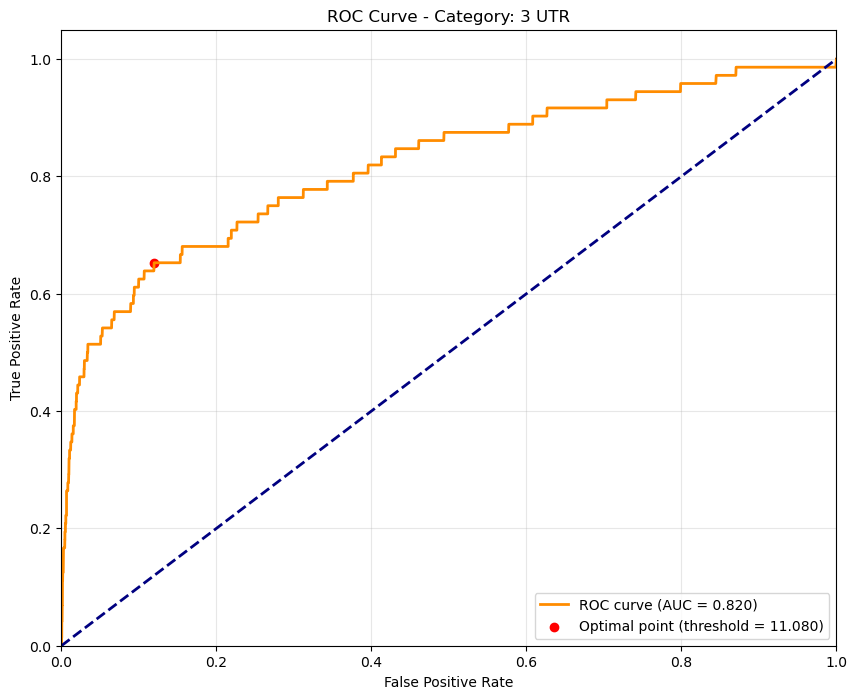

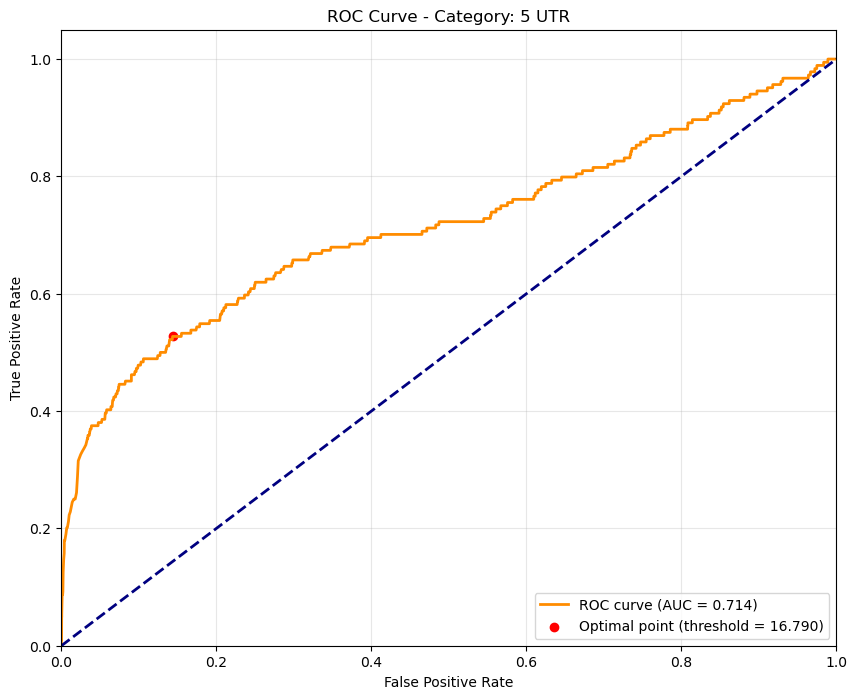

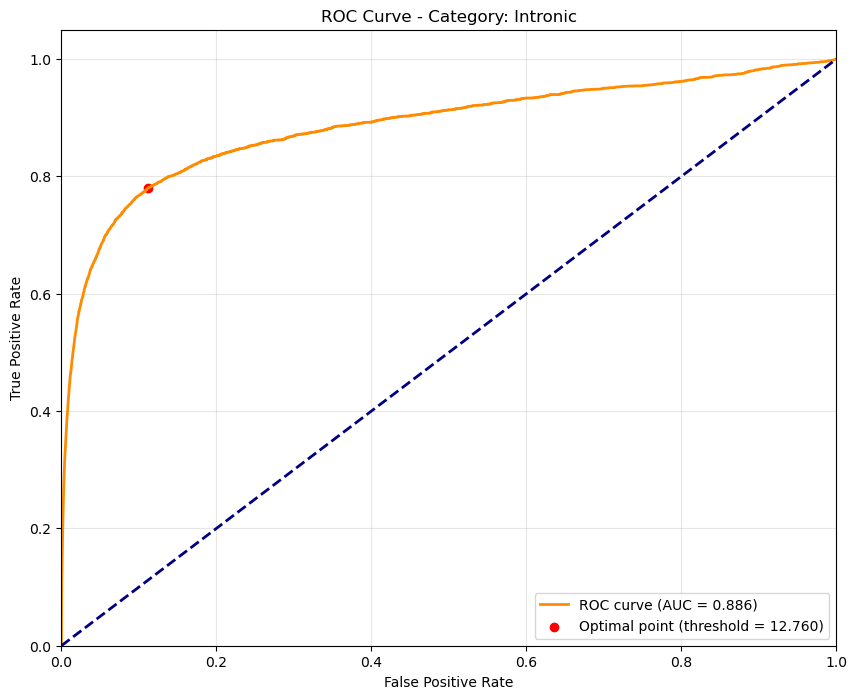

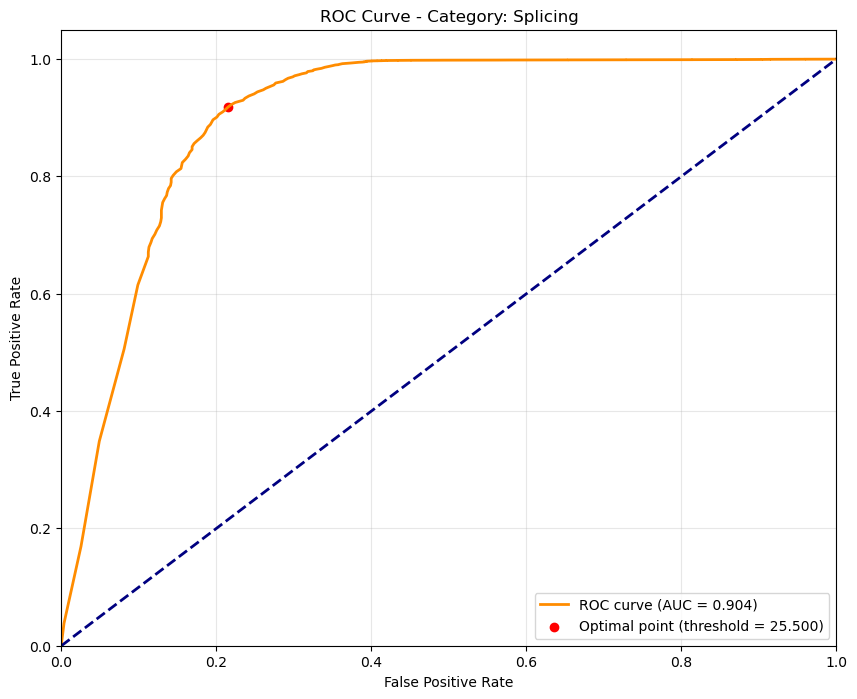

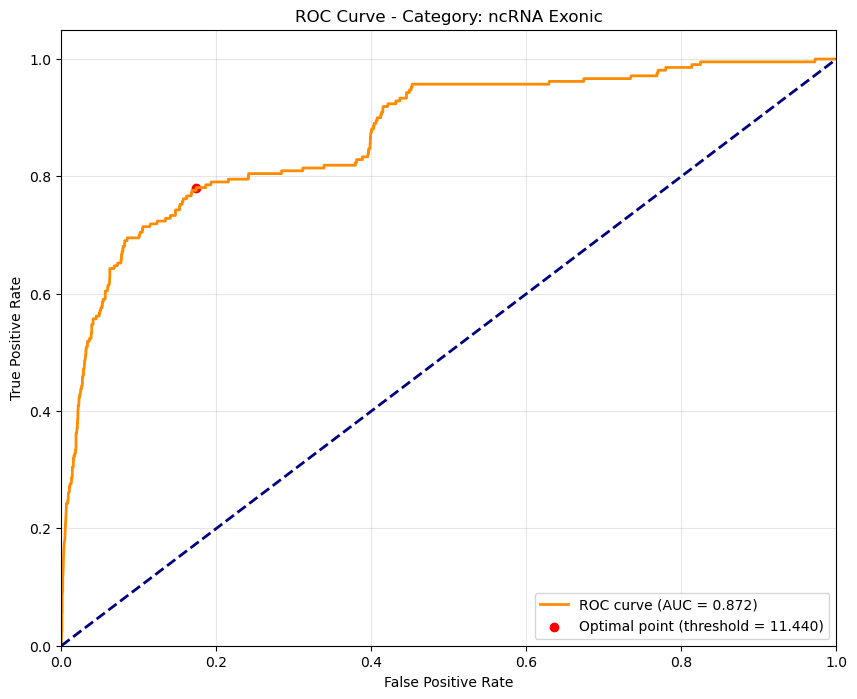

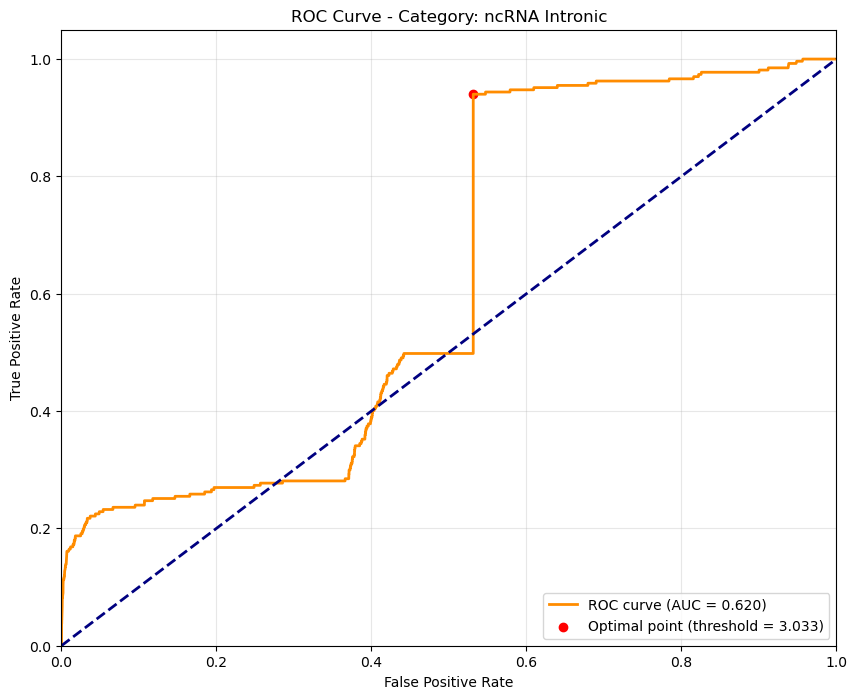

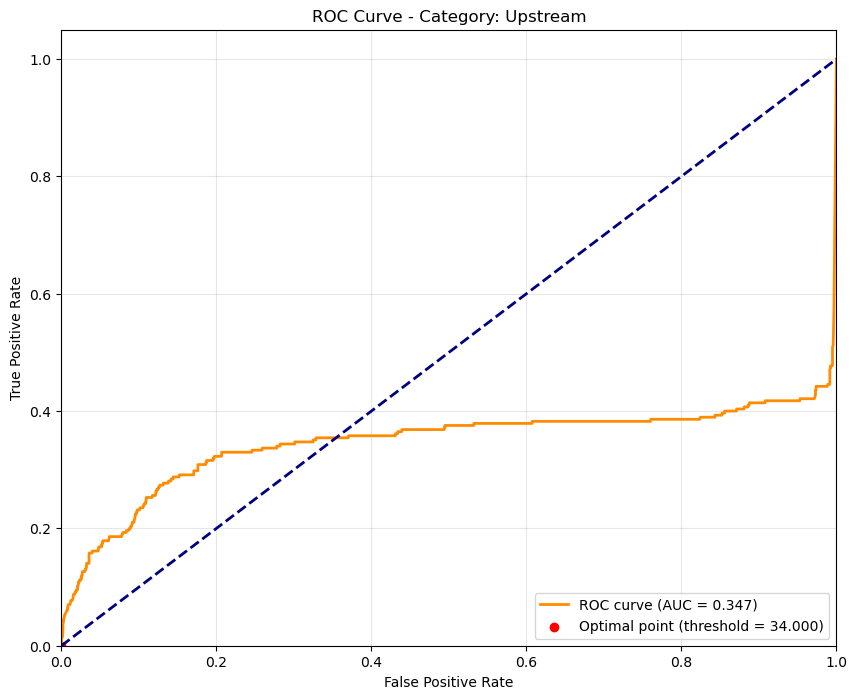

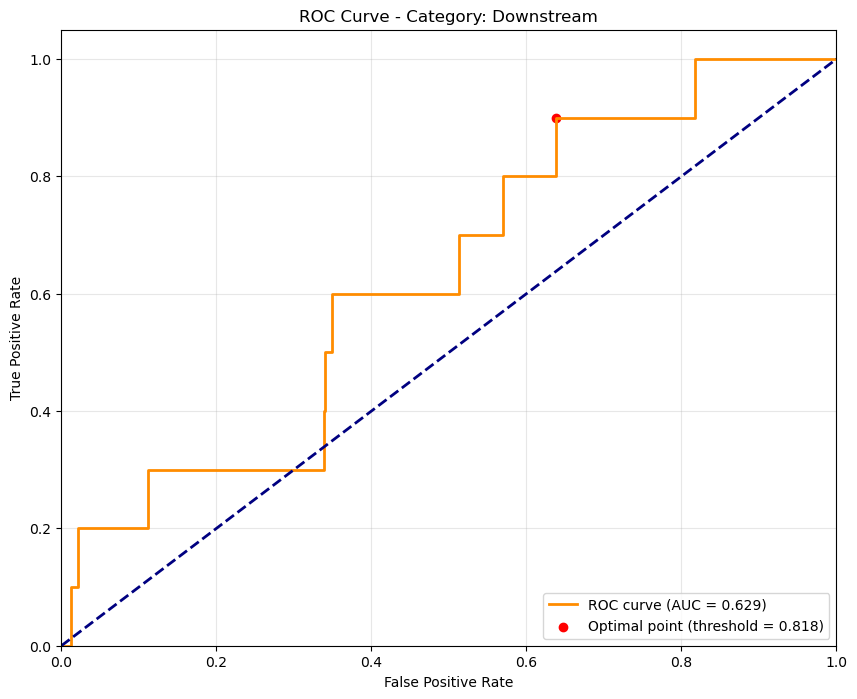

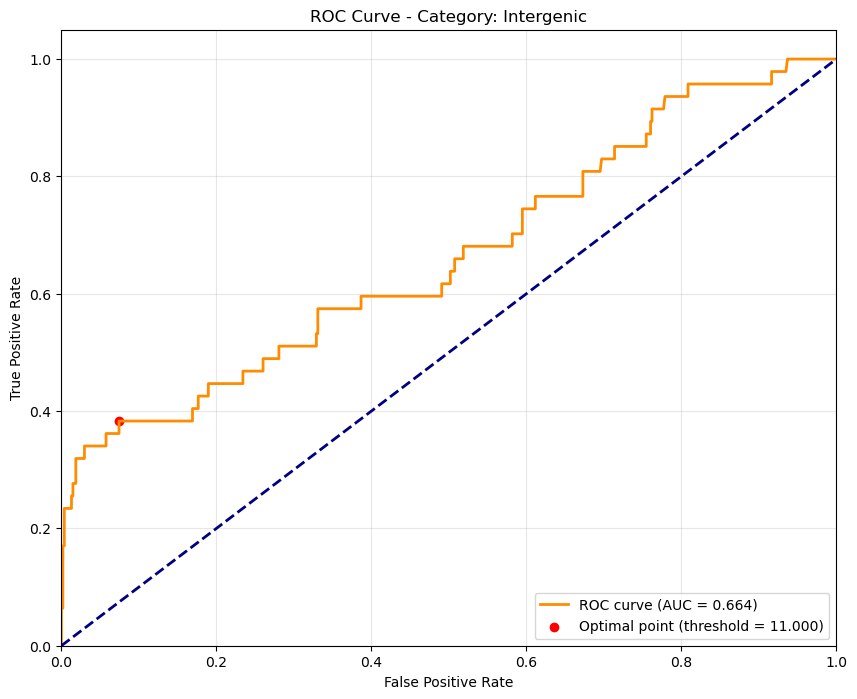


Detailed Category Statistics and Thresholds:
----------------------------------------------------------------------------------------------------
Category           Total     Path   Benign      AUC           Path Range         Benign Range  Threshold
----------------------------------------------------------------------------------------------------
Upstream            4656      285     4371    0.347        [0.00, 34.00]        [0.00, 24.20]    34.0000
Splicing           36589    35403     1186    0.904        [0.01, 47.00]        [0.01, 36.00]    25.5000
5 UTR               9056      184     8872    0.714        [0.06, 38.00]        [0.00, 31.00]    16.7900
Intronic          396554     3718   392836    0.886        [0.00, 67.00]        [0.00, 38.00]    12.7600
ncRNA Exonic        3125      210     2915    0.872        [0.04, 39.00]        [0.00, 23.90]    11.4400
3 UTR              22657       72    22585    0.820        [0.00, 23.80]        [0.00, 34.00]    11.0800
Intergenic       

In [17]:
CADDPoptimized_thresholds1, statis1, results_table = optimize_thresholds1(
    CADDPthresh, 
    'CADDP', 
    category_column='Func_refGene',
    save_table=True
)

Areas under the ROC curves:
{'Upstream': 0.34668007240705284, '5 UTR': 0.7140974781432547, 'Intronic': 0.886091537070131, 'Splicing': 0.9037461883714373, '3 UTR': 0.8195665141563968, 'ncRNA Exonic': 0.8716523727844483, 'ncRNA Intronic': 0.6204785863677099, 'Downstream': 0.6288858321870702, 'Intergenic': 0.6636676421735348}


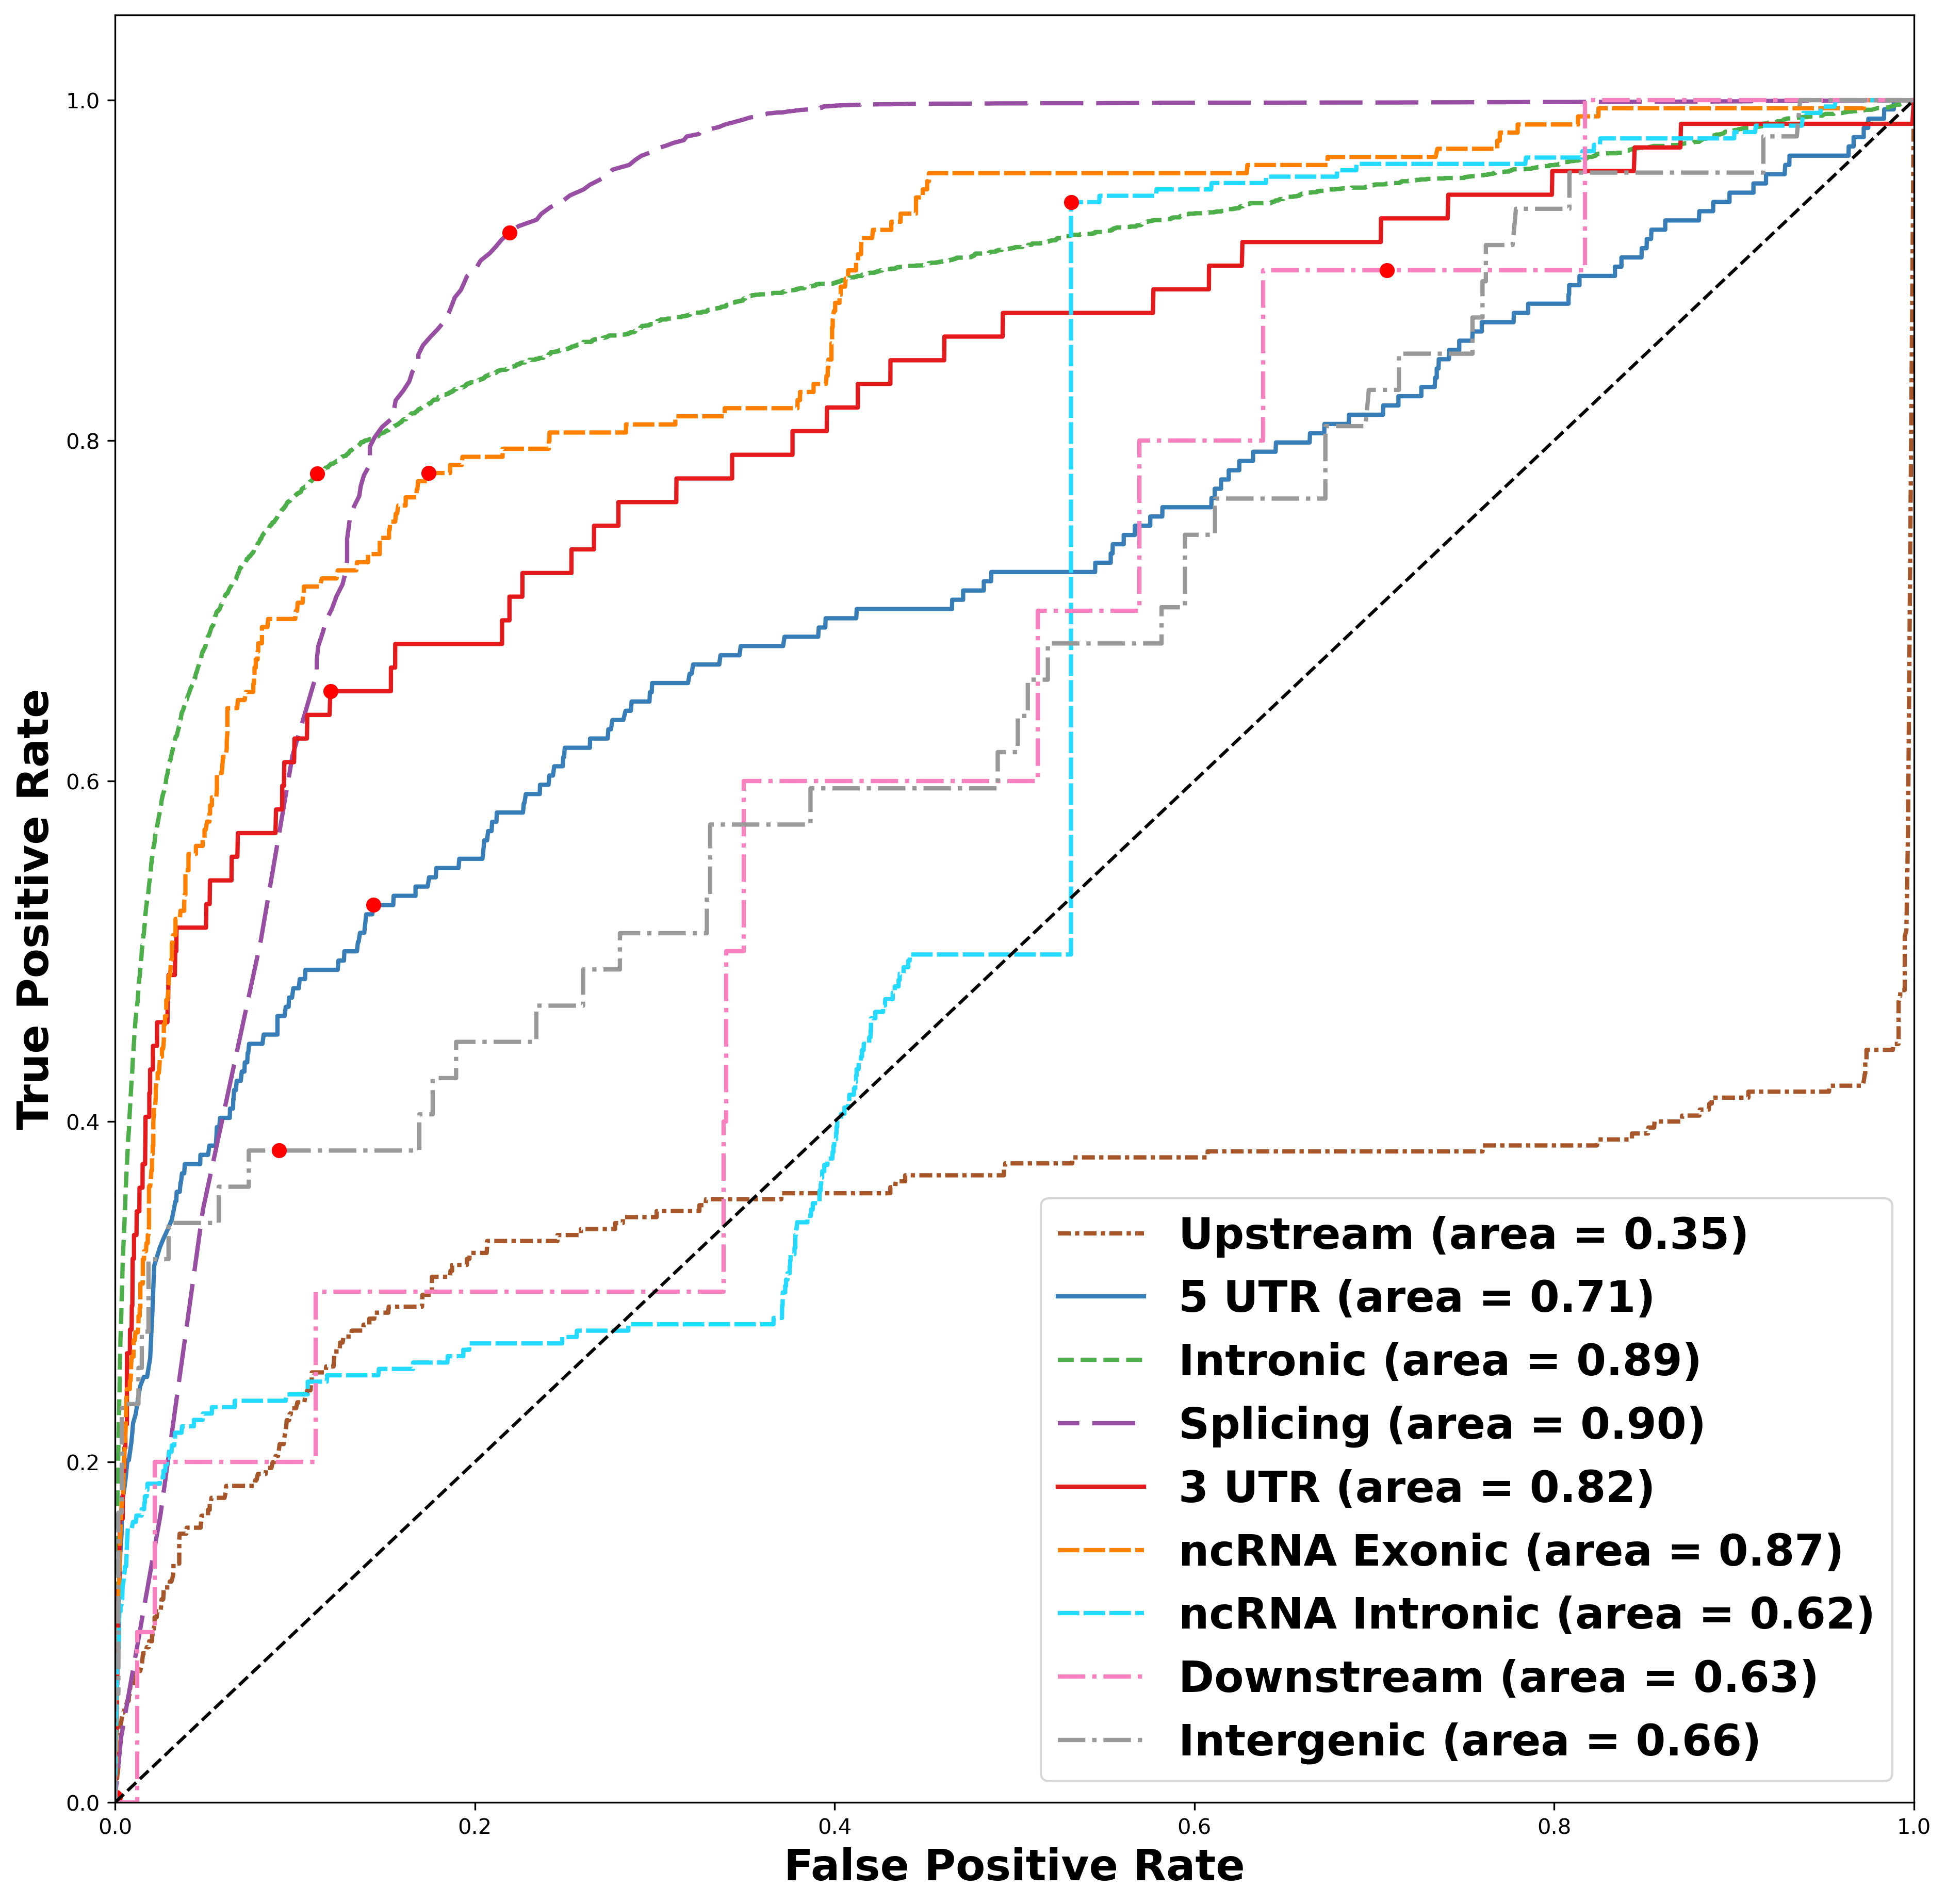

In [18]:
plot_roc_curves(CADDPthresh, CADDPoptimized_thresholds, numeric_column='CADDP', category_column='Func_refGene')

# Boxplot Research Letter

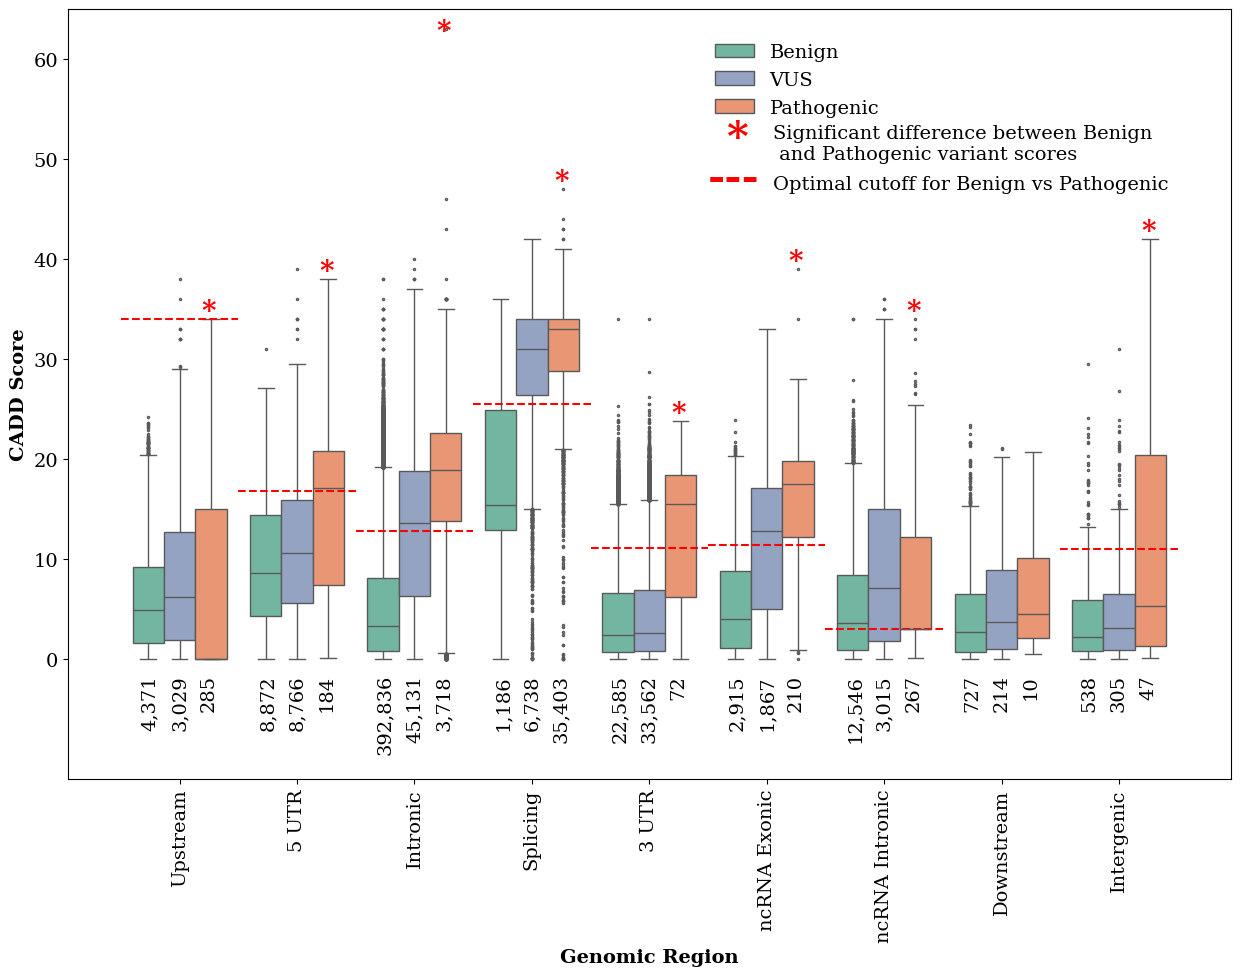

In [19]:

patho_label_dict = OrderedDict([('Benign', '#66C2A5'), ('VUS', '#8DA0CB'), ('Pathogenic', '#FC8D62')])

# Filter out orders with no non-NaN data in the CADDP column
orders = ["Upstream", "5 UTR", "Intronic", "Splicing", "3 UTR", "ncRNA Exonic", "ncRNA Intronic", "Downstream", "Intergenic"]

data_categCADDP = [category for category in orders if not CADDP_1[(CADDP_1['Func_refGene'] == category) & (CADDP_1['CADDP'].notna())].empty]
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Calibri']

palette = [patho_label_dict["Benign"], patho_label_dict["VUS"], patho_label_dict["Pathogenic"]]

# Create a boxplot for each category of Func_refGene, with separate boxes for each CLNSIG category
plt.figure(figsize=(15,10))
cadddata = CADDP_1.copy()
#cadddata['CLNSIG'].replace('Variant of Uncertain Significance', 'VUS', inplace=True)
ax = sns.boxplot(x="Func_refGene", y="CADDP", hue="CLNSIG", data=cadddata, order=data_categCADDP, hue_order=['Benign', 'VUS', 'Pathogenic'], palette=palette, fliersize=1.5, linewidth=1)


# Rotate x-axis labels for readability
plt.xticks(rotation=90)

cfiltered_df = cadddata[cadddata['CADDP'].notna()].copy()

# Calculate the total number of records for each category and CLNSIG
counts = cfiltered_df.groupby(['Func_refGene', 'CLNSIG']).size()

# Define the offset for each CLNSIG category
offsets = {'Benign': -0.25, 'VUS': 0, 'Pathogenic': 0.25}

#plt.title('Distribution of CADD scores by genomic region and variant Clinical Significance', fontweight='bold')  # Add padding to the title
plt.xlabel('Genomic Region',fontweight='bold')
plt.ylabel('CADD Score',fontweight='bold')

plt.ylim(-12, 65)
plt.yticks([0, 10, 20, 30, 40, 50, 60])

plt.legend(loc=(0.55, 0.85), frameon=False)
plt.text(5.05, 50, "Significant difference between Benign \n and Pathogenic variant scores")
plt.text(4.65, 51, '*', ha='left', fontsize=30, color='red',fontweight='bold')
plt.text(5.05, 47, "Optimal cutoff for Benign vs Pathogenic")
plt.text(4.50, 47, '---', ha='left', fontsize=30, color='red',fontweight='bold')


# Display the total number of records for each category and CLNSIG on the plot
for i, category in enumerate(data_categCADDP):
    for clnsig in ['Benign', 'VUS', 'Pathogenic']:
        plt.text(i + offsets[clnsig], -1.5, format(counts.get((category, clnsig), 0), ','), va = 'top', ha = 'center', rotation=90)
    
    # # If the reject status for this category is True, add a star above the category name
    if CADDP_p_values_dict.get(category, 1) < 0.05:
    #     # Calculate the maximum 'CADDP' value for the 'Pathogenic' category in this 'Func_refGene' category
        max_value = cfiltered_df[(cfiltered_df['Func_refGene'] == category) & (cfiltered_df['CLNSIG'] == 'Pathogenic')]['CADDP'].max()
        # Add a small offset to the maximum value to place the star slightly above the box plot
        y_coordinate = max_value
        #Ensure stars stay in plot limit
        if y_coordinate > 65:
            y_coordinate = 62
        plt.text(i + offsets['Pathogenic'], y_coordinate, '*', ha='center', fontsize=20, color='red',fontweight='bold')

        if category in CADDPoptimized_thresholds and not np.isnan(CADDPoptimized_thresholds[category]):
        #     # Calculate the start and end points of the line on the x-axis
            start = i - 0.5  # Start to the left of the first box
            end = i + 0.5  # End to the right of the last box
            plt.hlines(y=CADDPoptimized_thresholds[category], xmin=start, xmax=end, color='r', linestyle='--', linewidth=1.5)


# Show the plot
# plt.savefig(#TODO, dpi=300, bbox_inches = 'tight')
plt.show()